C:\Users\sande\AppData\Local\Temp\ipykernel_8540\2781135514.py:55: RuntimeWarning: Mean of empty slice.
  x = (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\ProgramData\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\ProgramData\

Epoch: 01, Loss: 0.6955, Val Acc: 0.4897, Val ROC-AUC: 0.7270
Epoch: 02, Loss: 0.6760, Val Acc: 0.6648, Val ROC-AUC: 0.7355
Epoch: 03, Loss: 0.6134, Val Acc: 0.6933, Val ROC-AUC: 0.7590
Epoch: 04, Loss: 0.5818, Val Acc: 0.7039, Val ROC-AUC: 0.7763
Epoch: 05, Loss: 0.5696, Val Acc: 0.7079, Val ROC-AUC: 0.7885
Epoch: 06, Loss: 0.5535, Val Acc: 0.7109, Val ROC-AUC: 0.7990
Epoch: 07, Loss: 0.5428, Val Acc: 0.7284, Val ROC-AUC: 0.8103
Epoch: 08, Loss: 0.5327, Val Acc: 0.7324, Val ROC-AUC: 0.8172
Epoch: 09, Loss: 0.5260, Val Acc: 0.7419, Val ROC-AUC: 0.8231
Epoch: 10, Loss: 0.5168, Val Acc: 0.7494, Val ROC-AUC: 0.8312
Epoch: 11, Loss: 0.5063, Val Acc: 0.7584, Val ROC-AUC: 0.8364
Epoch: 12, Loss: 0.5027, Val Acc: 0.7574, Val ROC-AUC: 0.8370
Epoch: 13, Loss: 0.4994, Val Acc: 0.7614, Val ROC-AUC: 0.8407
Epoch: 14, Loss: 0.4958, Val Acc: 0.7709, Val ROC-AUC: 0.8430
Epoch: 15, Loss: 0.4860, Val Acc: 0.7689, Val ROC-AUC: 0.8448
Epoch: 16, Loss: 0.4831, Val Acc: 0.7709, Val ROC-AUC: 0.8471
Epoch: 1

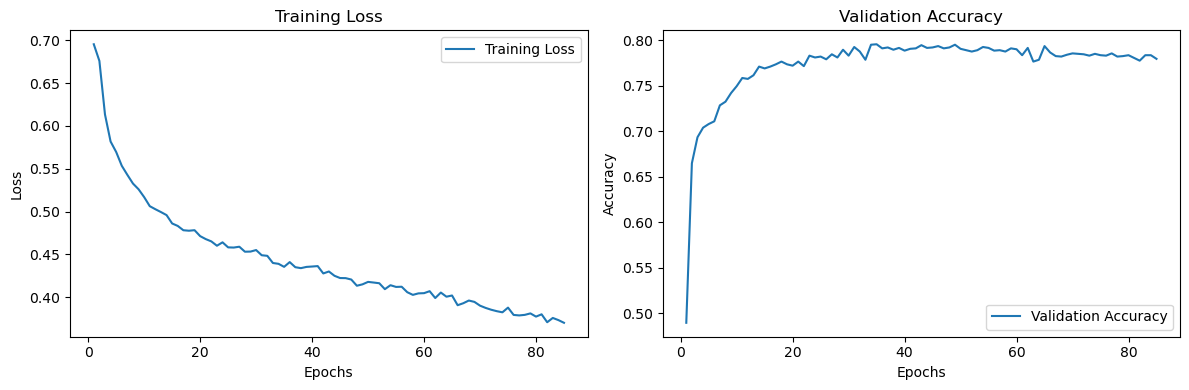

In [23]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import uproot
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Configuration
features = ['Jet.PT',  'Jet.Phi', 'Jet.Mass', 'Jet.NCharged','Jet.EhadOverEem',
            'Jet.Eta','Jet.BTag','Jet.Flavor','Jet.T','Jet.DeltaEta',
            'Jet.DeltaPhi','Jet.ChargedEnergyFraction','Jet.NeutralEnergyFraction',]
# signal_file = '13TeV_signal.root'
# background_file = '13TeV_BKG.root'
# signal_file = '100TeV_signal.root'
# background_file = '100TeV_BKG.root'
signal_file = '13TeV_signal_5k.root'
background_file = '13TeV_BKG_5k.root'
tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 2.45  # For delta-R based edge construction
hidden_dim = 128
epochs = 100
patience = 20  # For early stopping

# 1. Data Preparation
def load_data(file_path, label):
    """Load ROOT file and create PyG Data objects"""
    file = uproot.open(file_path)
    tree = file[tree_name]
    data_list = []
    
    # Load all events as a dictionary of arrays
    jets = tree.arrays(features, library='np')
    
    # Get number of events from the first feature's array length
    num_events = len(jets[features[0]])
    
    for i in range(num_events):
        # Collect features for this event
        event_data = []
        for feat in features:
            # Get jet values for this feature and event
            feat_values = jets[feat][i]
            event_data.append(feat_values)
        
        # Create feature matrix (num_jets × num_features)
        x = np.column_stack(event_data)
        x = np.nan_to_num(x)  # Replace NaNs with 0
        
        # Normalize features
        x = (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)
        
        num_nodes = x.shape[0]
        if num_nodes == 0:
            continue  # Skip events with no jets
        
        # Create edges based on delta-R
        eta = x[:, 1]  # eta is the second feature
        phi = x[:, 2]  # phi is the third feature
        edge_index = create_delta_r_edges(eta, phi, delta_r_threshold)
        
        data = Data(
            x=torch.tensor(x, dtype=torch.float),
            edge_index=edge_index,
            y=torch.tensor([label], dtype=torch.float)
        )
        data_list.append(data)
    
    return data_list

def create_delta_r_edges(eta, phi, delta_r_threshold):
    """Create edges based on delta-R distance between jets"""
    edge_index = []
    num_nodes = len(eta)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            delta_eta = eta[i] - eta[j]
            delta_phi = (phi[i] - phi[j] + np.pi) % (2 * np.pi) - np.pi
            delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
            if delta_r < delta_r_threshold:
                edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Load signal and background
signal_data = load_data(signal_file, label=1)
background_data = load_data(background_file, label=0)

# Combine and shuffle datasets
dataset = signal_data + background_data
np.random.shuffle(dataset)

# Split train/test
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

class EventClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(len(features), hidden_dim, heads=4)
        self.conv2 = GATConv(hidden_dim * 4, hidden_dim // 2, heads=2)
        self.conv3 = GATConv(hidden_dim, hidden_dim // 4)
        self.conv4 = GATConv(hidden_dim // 4, hidden_dim // 4)
        self.conv5 = GATConv(hidden_dim // 4, hidden_dim // 4)
        self.fc = torch.nn.Linear(hidden_dim // 4, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv4(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv5(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x).squeeze(-1)

# 3. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EventClassifier().to(device)

# Class weights for imbalanced data
labels = [data.y.item() for data in dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# 4. Training Loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_data)

# 5. Testing Loop
def test(loader):
    model.eval()
    correct = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = torch.sigmoid(model(data.x, data.edge_index, data.batch))
            correct += ((pred > 0.5) == data.y).sum().item()
            y_true.append(data.y.cpu())
            y_pred.append(pred.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    roc_auc = roc_auc_score(y_true, y_pred)
    return correct / len(loader.dataset), roc_auc

# 6. Run Training
best_val_acc = 0
counter = 0

# for epoch in range(1, epochs + 1):
#     loss = train()
#     val_acc, val_roc_auc = test(test_loader)
#     scheduler.step(val_roc_auc)
    
#     print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}')
    
#     if val_roc_auc > best_val_acc:
#         best_val_acc = val_roc_auc
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print(f"Early stopping at epoch {epoch}")
#             break


# Initialize lists to store metrics
train_losses = []
val_accuracies = []
val_roc_aucs = []

# Modified training loop to store metrics
best_val_acc = 0
counter = 0

for epoch in range(1, epochs + 1):
    loss = train()
    val_acc, val_roc_auc = test(test_loader)
    scheduler.step(val_roc_auc)
    
    train_losses.append(loss)
    val_accuracies.append(val_acc)
    val_roc_aucs.append(val_roc_auc)
    
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}')
    
    if val_roc_auc > best_val_acc:
        best_val_acc = val_roc_auc
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# Plotting
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

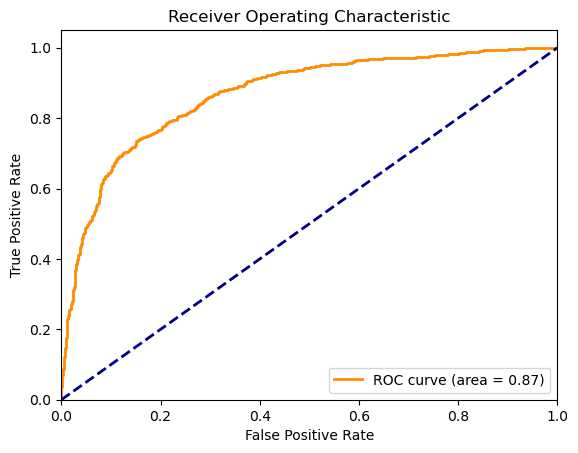

In [24]:
from sklearn.metrics import roc_curve, auc

# Get true labels and predicted probabilities
y_true = []
y_pred = []

model.eval()
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(data.x, data.edge_index, data.batch))
        y_true.append(data.y.cpu().numpy())
        y_pred.append(pred.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [25]:
total_weights = 0
total_biases = 0

for name, param in model.named_parameters():
    if "weight" in name:
        total_weights += param.numel()
    elif "bias" in name:
        total_biases += param.numel()
    print(f"Parameter: {name}, Shape: {param.shape}")

print(f"Total Weights: {total_weights}")
print(f"Total Biases: {total_biases}")

Parameter: conv1.att_src, Shape: torch.Size([1, 4, 128])
Parameter: conv1.att_dst, Shape: torch.Size([1, 4, 128])
Parameter: conv1.bias, Shape: torch.Size([512])
Parameter: conv1.lin.weight, Shape: torch.Size([512, 13])
Parameter: conv2.att_src, Shape: torch.Size([1, 2, 64])
Parameter: conv2.att_dst, Shape: torch.Size([1, 2, 64])
Parameter: conv2.bias, Shape: torch.Size([128])
Parameter: conv2.lin.weight, Shape: torch.Size([128, 512])
Parameter: conv3.att_src, Shape: torch.Size([1, 1, 32])
Parameter: conv3.att_dst, Shape: torch.Size([1, 1, 32])
Parameter: conv3.bias, Shape: torch.Size([32])
Parameter: conv3.lin.weight, Shape: torch.Size([32, 128])
Parameter: conv4.att_src, Shape: torch.Size([1, 1, 32])
Parameter: conv4.att_dst, Shape: torch.Size([1, 1, 32])
Parameter: conv4.bias, Shape: torch.Size([32])
Parameter: conv4.lin.weight, Shape: torch.Size([32, 32])
Parameter: conv5.att_src, Shape: torch.Size([1, 1, 32])
Parameter: conv5.att_dst, Shape: torch.Size([1, 1, 32])
Parameter: conv5

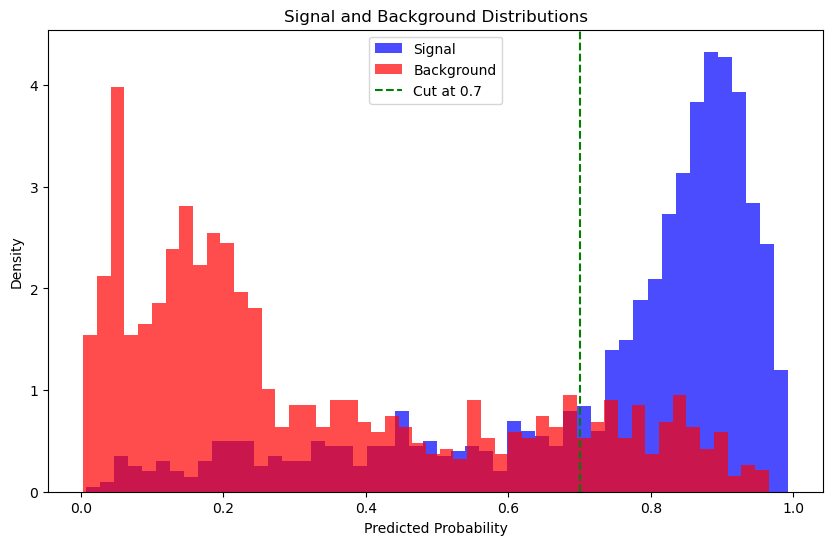

In [27]:
import matplotlib.pyplot as plt

# Separate signal and background predictions
signal_preds = y_pred[y_true == 1]
background_preds = y_pred[y_true == 0]

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(signal_preds, bins=50, alpha=0.7, label='Signal', color='blue', density=True)
plt.hist(background_preds, bins=50, alpha=0.7, label='Background', color='red', density=True)

# Add a vertical line for the cut
cut_value = 0.7
plt.axvline(cut_value, color='green', linestyle='--', label=f'Cut at {cut_value}')

# Add labels and legend
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Signal and Background Distributions')
plt.legend()
plt.show()

In [28]:
def calculate_significance_from_predictions(y_true, y_pred, cut_value=0.7):
    """Calculate significance based on true labels and predicted probabilities."""
    signal_count = ((y_pred > cut_value) & (y_true == 1)).sum()
    background_count = ((y_pred > cut_value) & (y_true == 0)).sum()
    
    if background_count == 0:
        return float('inf')
    
    significance = signal_count / np.sqrt(background_count)
    return significance

# Calculate significance
cut_value = 0.8  # You can adjust this threshold as needed
significance = calculate_significance_from_predictions(y_true, y_pred, cut_value=cut_value)
print(f'Significance: {significance:.4f}')

Significance: 69.5160


### Comments
1. we see rise in auc of ROC curve when we increase conv layers and data size.</br>
2. In this model we have used 5k signal and 5k BKG events.</br>
3. we can train this moedl and get more good results.